In [1]:
import ase
from ase import Atoms
from ase.io import read,write
import numpy as np
from pyace import PyACECalculator
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import glob
from itertools import cycle
mpl.rcParams['figure.dpi'] = 150
plt.style.use('~/plot.mplstyle')


In [2]:
def get_ace_energies(frames, pot):
    ace_energies=[]
    # ace_forces=np.zeros((len(frames),3))

    for atoms in frames:
        atoms.calc=pot
        ace_energies.append(atoms.get_potential_energy(force_consistent=True)/len(atoms))
    
    ace_energies=np.asarray(ace_energies)

    return ace_energies

In [3]:
def get_ace_forces(frames, pot):
    ace_forces=[]
    # ace_forces=np.empty((len(frames)))

    for i in range(len(frames)):
        atoms=frames[i]
        atoms.calc=pot
        
        forces=atoms.get_forces()
        # print(forces)
        ace_forces.append(forces)

    ace_forces=np.vstack(ace_forces)
        
    return ace_forces

In [7]:
### GAP22
df=pd.read_pickle('../../data/datasets/SCAN-SiH-GAP-22_training.pkl.gzip',compression="gzip")


[[162.31516115 175.77533758 220.88904087]
 [157.42175369 160.82411415 176.61703425]
 [160.55232518 234.5487391  155.58667375]
 [160.2423092  268.27875707 160.44983679]
 [158.28520968 215.62430818 175.13443897]]
[[146.76662754 152.57894954 207.54536004]
 [142.0491715  144.90682799 152.48896098]
 [143.8000474  187.03475141 141.98039618]
 [145.67179316 200.79841727 145.07743654]
 [143.38677055 168.05217091 155.8507283 ]]
[[299.89368879 362.87793411 352.75768027]
 [292.7406213  300.42765507 369.14085587]
 [305.3551258  565.74299993 278.89198993]
 [290.95878893 700.58045992 296.46382722]
 [290.73138312 536.66444435 339.30375648]]
[[193.27297517 172.71158239 146.54487006]
 [190.43993743 181.87695304 170.9868081 ]
 [329.35894294 197.71260561 165.69615613]
 [201.20536347 182.36731313 171.44667348]
 [474.64265794 170.08691029 225.83636833]]
[[168.10938168 159.99112303 132.45343808]
 [174.66258328 157.79091522 155.98759587]
 [304.91548246 168.28550449 153.71892303]
 [160.23909666 164.4136092  15

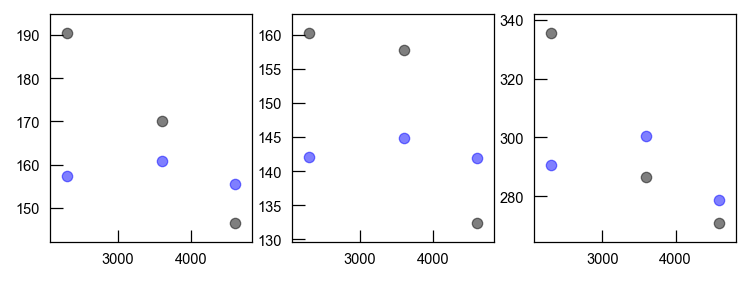

In [10]:
color='b'
cm=1/2.54

# n_funcs=np.array((500,575,750,900,1000,1150,1250,1500))
n_funcs=[2300, 3600, 4600]

df=pd.read_pickle('../../data/datasets/SCAN-SiH-GAP-22_training.pkl.gzip',compression="gzip")
frames=df.ase_atoms.values.tolist()

numbers=[atoms.numbers for atoms in df.ase_atoms]
numbers=[x for xs in numbers for x in xs]
numbers=np.asarray(numbers)

dft_energies=df.e_corrected_per_atom.values

dft_forces=np.concatenate(df.forces.values)

dft_forces_Si=dft_forces[numbers==14]
dft_forces_H=dft_forces[numbers==1]
dft_forces_Si = dft_forces_Si.ravel()
dft_forces_H = dft_forces_H.ravel()

dft_forces = dft_forces.ravel()

rmse_f=np.zeros((5, len(n_funcs)))
rmse_f_Si=np.zeros((5, len(n_funcs)))
rmse_f_H=np.zeros((5, len(n_funcs)))

fig, axes= plt.subplots(1,3, figsize=(15*cm,5*cm))

for i in range(len(n_funcs)):
    nfunc=n_funcs[i]
    wdir=f'../../models/symmetry/asymmetric/{nfunc}'
    # print(wdir)
    for sub in np.arange(1,6):
        try:
            ace_forces=np.loadtxt(f'{wdir}/{sub}/GAP22_force_preds.txt')

        except:
            pot=PyACECalculator(f'{wdir}/{sub}/output_potential.yaml')
            ace_forces=get_ace_forces(frames, pot)
            np.savetxt(f'{wdir}/{sub}/GAP22_force_preds.txt', ace_forces)

        forces_si = ace_forces[numbers == 14]
        forces_h = ace_forces[numbers == 1]

        ace_forces = np.concatenate(ace_forces).ravel()
        forces_si = np.concatenate(forces_si).ravel()
        forces_h = np.concatenate(forces_h).ravel()

        rmse_f_Si[sub-1,i] = np.sqrt(np.mean((dft_forces_Si - forces_si)**2)) * 1e3
        rmse_f_H[sub-1,i] = np.sqrt(np.mean((dft_forces_H - forces_h)**2)) * 1e3
        rmse_f[sub-1,i] = np.sqrt(np.mean((dft_forces - ace_forces)**2)) * 1e3


rmse_f_av=np.min(rmse_f, axis=0)
# rmse_f_std=np.std(rmse_f, axis=0)
axes[0].scatter(n_funcs, rmse_f_av, c=color, alpha=0.5)
# axes[0].errorbar(n_funcs, rmse_f_av, yerr=rmse_f_std, color=color,  capsize=2.5)

rmse_f_Si_av=np.min(rmse_f_Si, axis=0)
# rmse_f_Si_std=np.std(rmse_f_Si, axis=0)
axes[1].scatter(n_funcs, rmse_f_Si_av, c=color, alpha=0.5)
# axes[1].errorbar(n_funcs, rmse_f_Si_av, yerr=rmse_f_Si_std, color=color,  capsize=2.5)

rmse_f_H_av=np.min(rmse_f_H, axis=0)
# rmse_f_H_std=np.std(rmse_f_H, axis=0)
axes[2].scatter(n_funcs, rmse_f_H_av, c=color, alpha=0.5)
# axes[2].errorbar(n_funcs, rmse_f_H_av, yerr=rmse_f_H_std, color=color, capsize=2.5)

print(rmse_f)
print(rmse_f_Si)
print(rmse_f_H)


color='k'
cm=1/2.54

# n_funcs=np.array((500,575,750,900,1000,1150,1250,1500))
n_funcs=[2300, 3600, 4600]

df=pd.read_pickle('../../data/datasets/SCAN-SiH-GAP-22_training.pkl.gzip',compression="gzip")
frames=df.ase_atoms.values.tolist()

numbers=[atoms.numbers for atoms in df.ase_atoms]
numbers=[x for xs in numbers for x in xs]
numbers=np.asarray(numbers)

dft_energies=df.e_corrected_per_atom.values

dft_forces=np.concatenate(df.forces.values)

dft_forces_Si=dft_forces[numbers==14]
dft_forces_H=dft_forces[numbers==1]
dft_forces_Si = dft_forces_Si.ravel()
dft_forces_H = dft_forces_H.ravel()

dft_forces = dft_forces.ravel()

rmse_e=np.zeros((5, len(n_funcs)))
rmse_f=np.zeros((5, len(n_funcs)))
rmse_f_Si=np.zeros((5, len(n_funcs)))
rmse_f_H=np.zeros((5, len(n_funcs)))

for i in range(len(n_funcs)):
    nfunc=n_funcs[i]
    wdir=f'../../models/symmetry/symmetric/{nfunc}'
    for sub in np.arange(1,6):
        try:
            ace_forces=np.loadtxt(f'{wdir}/{sub}/GAP22_force_preds.txt')

        except:
            pot=PyACECalculator(f'{wdir}/{sub}/output_potential.yaml')
            ace_forces=get_ace_forces(frames, pot)
            np.savetxt(f'{wdir}/{sub}/GAP22_force_preds.txt', ace_forces)

        forces_si = ace_forces[numbers == 14]
        forces_h = ace_forces[numbers == 1]

        ace_forces = np.concatenate(ace_forces).ravel()
        forces_si = np.concatenate(forces_si).ravel()
        forces_h = np.concatenate(forces_h).ravel()

        rmse_f_Si[sub-1,i] = np.sqrt(np.mean((dft_forces_Si - forces_si)**2)) * 1e3
        rmse_f_H[sub-1,i] = np.sqrt(np.mean((dft_forces_H - forces_h)**2)) * 1e3
        rmse_f[sub-1,i] = np.sqrt(np.mean((dft_forces - ace_forces)**2)) * 1e3

print(rmse_f)
print(rmse_f_Si)
print(rmse_f_H)


rmse_f_av=np.min(rmse_f, axis=0)

# rmse_f_std=np.std(rmse_f, axis=0)
axes[0].scatter(n_funcs, rmse_f_av, c=color, alpha=0.5)
# axes[0].errorbar(n_funcs, rmse_f_av, yerr=rmse_f_std, color=color,  capsize=2.5)

rmse_f_Si_av=np.min(rmse_f_Si, axis=0)
# rmse_f_Si_std=np.std(rmse_f_Si, axis=0)
axes[1].scatter(n_funcs, rmse_f_Si_av, c=color, alpha=0.5)
# axes[1].errorbar(n_funcs, rmse_f_Si_av, yerr=rmse_f_Si_std, color=color,  capsize=2.5)

rmse_f_H_av=np.min(rmse_f_H, axis=0)
# rmse_f_H_std=np.std(rmse_f_H, axis=0)
axes[2].scatter(n_funcs, rmse_f_H_av, c=color, alpha=0.5)
# axes[2].errorbar(n_funcs, rmse_f_H_av, yerr=rmse_f_H_std, color=color, capsize=2.5)

